In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
main_data = pd.read_excel('/content/Data-Traffic.xlsx')
clustered = pd.read_csv('/content/Final clusters(1).csv')

In [ ]:
main_data.head()

site      0      1      2      3      4      5      6      7      8  ...  \
0  A001  94.74  82.00  66.06  45.93  33.63  34.35  34.86  47.07  66.11  ...   
1  A002  42.50  28.61  18.84  11.92   9.63   8.60  12.40  35.17  57.36  ...   
2  A004  21.28  26.63  14.67   9.99   4.90   5.12   5.59   8.52  15.21  ...   
3  A005  73.77  61.79  44.45  45.26  31.08  34.43  30.58  42.26  56.88  ...   
4  A006  10.72   8.94   6.06   4.25   3.32   2.46   2.97   6.26  12.20  ...   

      14     15     16     17     18      19     20     21      22     23  
0  82.58  88.35  90.59  89.60  86.74   89.27  93.80  96.98  102.55  98.26  
1  64.85  67.13  77.83  80.89  73.70   64.08  58.77  71.91   64.69  55.23  
2  22.36  20.41  17.53  26.06  28.13   31.97  30.12  31.01   37.33  33.31  
3  66.75  69.61  73.11  91.47  90.71  100.15  96.00  95.71   87.17  85.33  
4  31.80  36.43  44.05  52.38  33.70   23.42  17.78  11.83   13.04  14.79  

[5 rows x 25 columns]

In [ ]:
clustered.head()

Unnamed: 0 BS Name               KMeans         LSTM          GRU  \
0           0    A001          Residential        Mixed  Residential   
1           1    A002                Mixed  Residential        Mixed   
2           2    A004          Residential  Residential  Residential   
3           3    A005          Residential  Residential  Residential   
4           4    A006  Business/Industrial        Mixed        Mixed   

                   TCN                voted  
0                Mixed                Mixed  
1  Business/Industrial                Mixed  
2          Residential          Residential  
3          Residential          Residential  
4  Business/Industrial  Business/Industrial

In [ ]:
def normalize_power(df):
    """Normalize each BS's power to [0, 1] range."""
    return (df - df.min()) / (df.max() - df.min())

main_data_normalized = main_data.copy()
main_data_normalized.iloc[:, 1:] = main_data_normalized.iloc[:, 1:].apply(
    normalize_power, axis=1
)

In [ ]:
# Melt normalized data
power_long_normalized = pd.melt(
    main_data_normalized,
    id_vars=['site'],
    var_name='hour',
    value_name='normalized_power'
)
power_long_normalized['hour'] = power_long_normalized['hour'].astype(int)

# Merge with clustered predictions
df_merged_normalized = power_long_normalized.merge(
    clustered[['BS Name', 'KMeans', 'LSTM', 'GRU', 'TCN']],
    left_on='site',
    right_on='BS Name'
)

In [ ]:
avg_curves_normalized = {}

for model in ['KMeans', 'LSTM', 'GRU', 'TCN']:
    for cls in ['Residential', 'Mixed', 'Business/Industrial']:
        # Filter BS sites of this class for the current model
        bs_list = clustered[clustered[model] == cls]['BS Name']
        # Get their normalized power data
        class_data = power_long_normalized[power_long_normalized['site'].isin(bs_list)]
        # Calculate mean normalized power per hour
        avg_power = class_data.groupby('hour')['normalized_power'].mean().values
        avg_curves_normalized[f"{model}_{cls}"] = avg_power

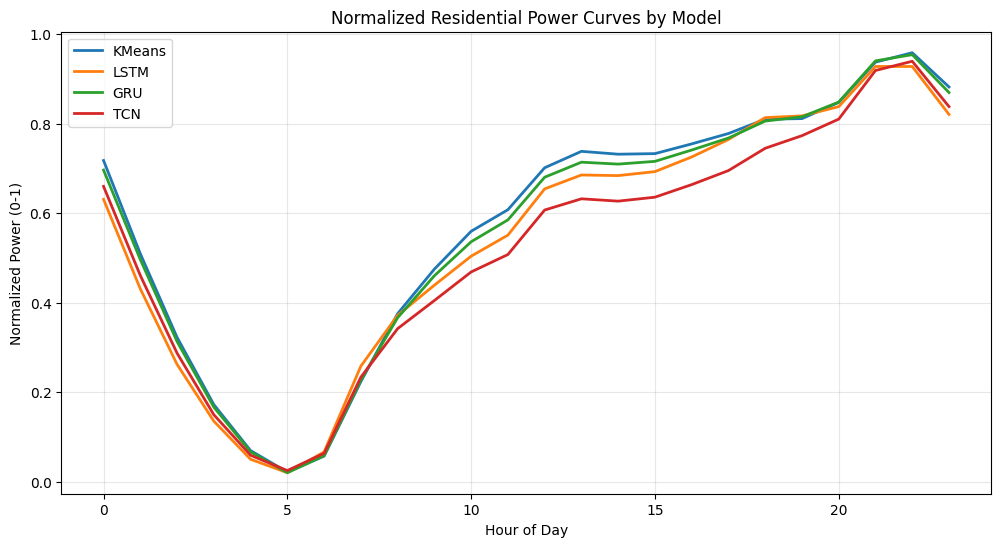

In [ ]:
plt.figure(figsize=(12, 6))
hours = np.arange(24)

for model in ['KMeans', 'LSTM', 'GRU', 'TCN']:
    plt.plot(
        hours,
        avg_curves_normalized[f"{model}_Residential"],
        label=model,
        linewidth=2
    )

plt.title("Normalized Residential Power Curves by Model")
plt.xlabel("Hour of Day")
plt.ylabel("Normalized Power (0-1)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

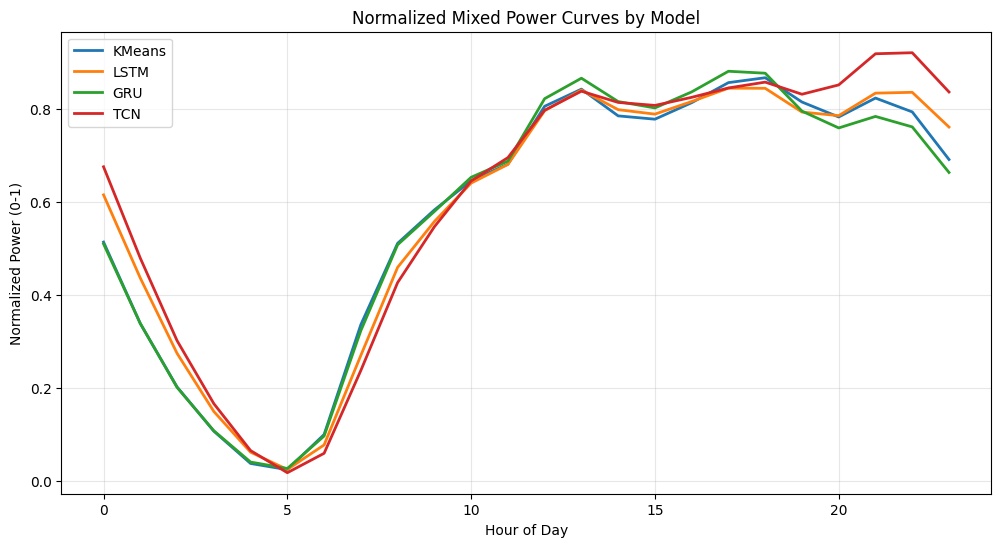

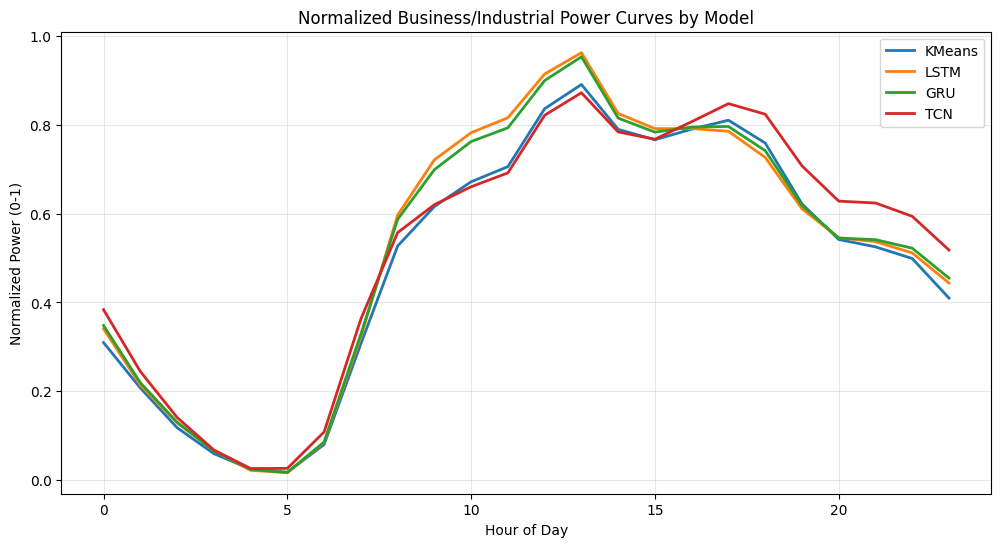

In [ ]:
for cls in ['Mixed', 'Business/Industrial']:
    plt.figure(figsize=(12, 6))
    for model in ['KMeans', 'LSTM', 'GRU', 'TCN']:
        plt.plot(
            hours,
            avg_curves_normalized[f"{model}_{cls}"],
            label=model,
            linewidth=2
        )
    plt.title(f"Normalized {cls} Power Curves by Model")
    plt.xlabel("Hour of Day")
    plt.ylabel("Normalized Power (0-1)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

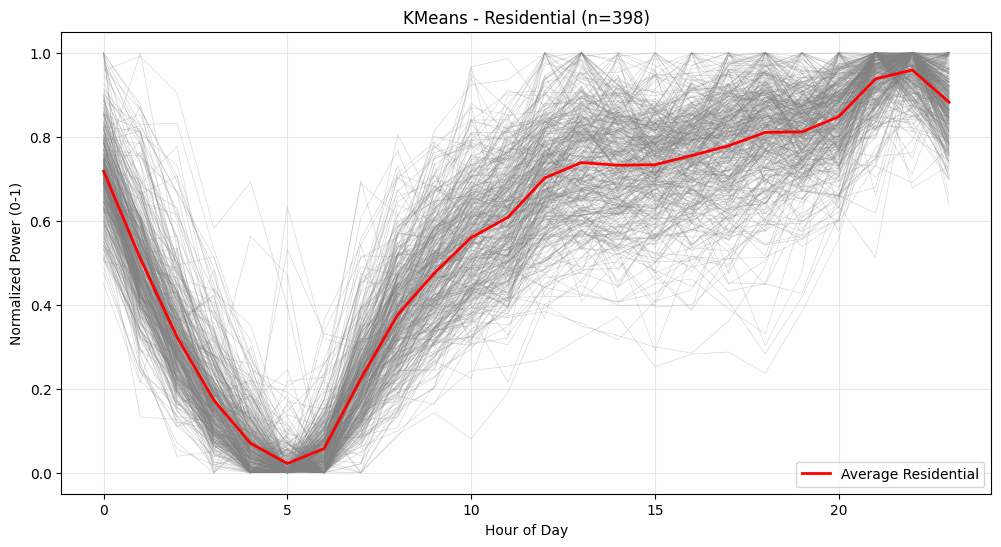

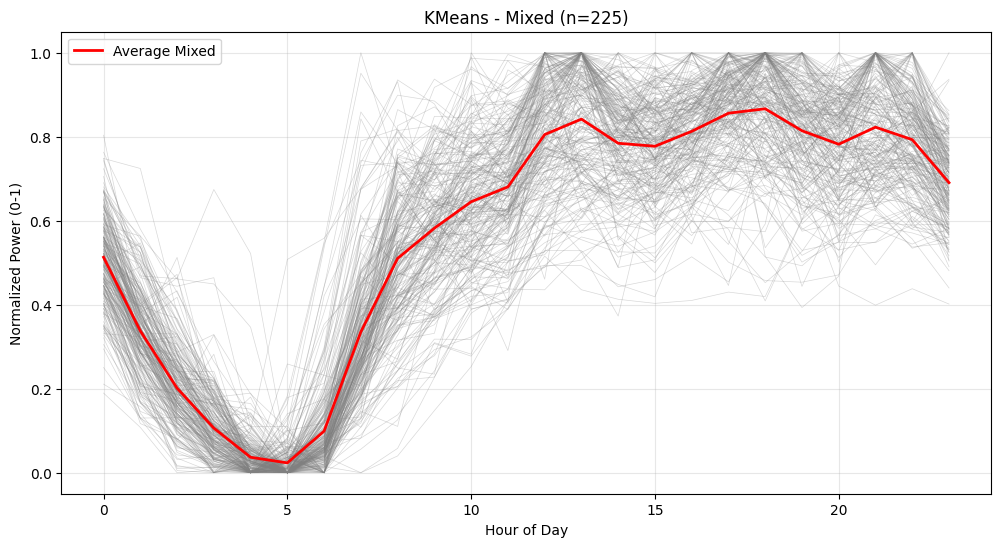

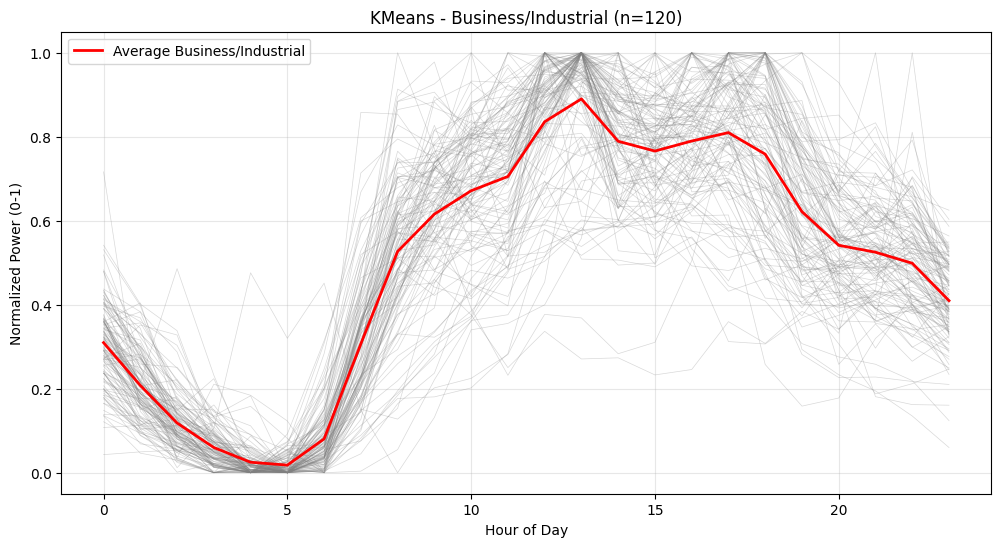

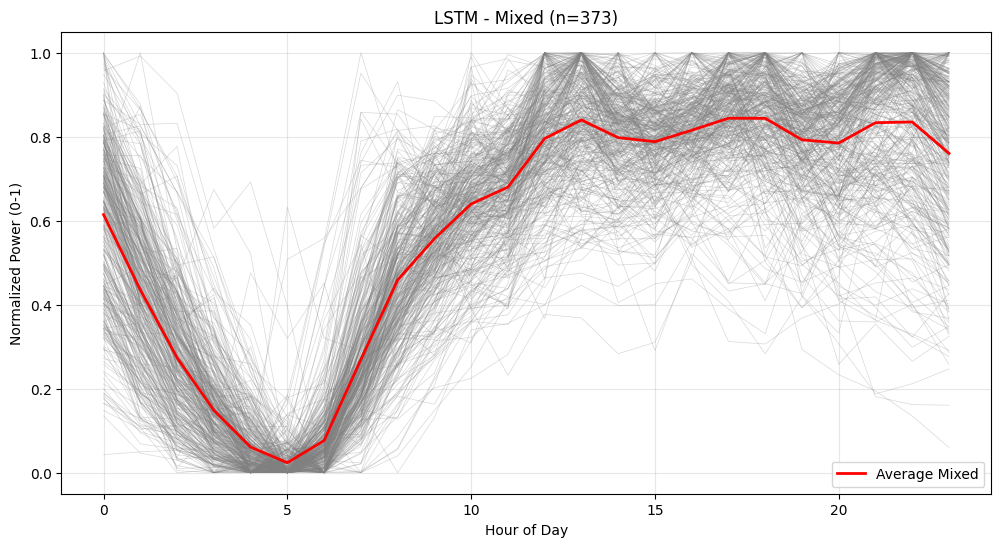

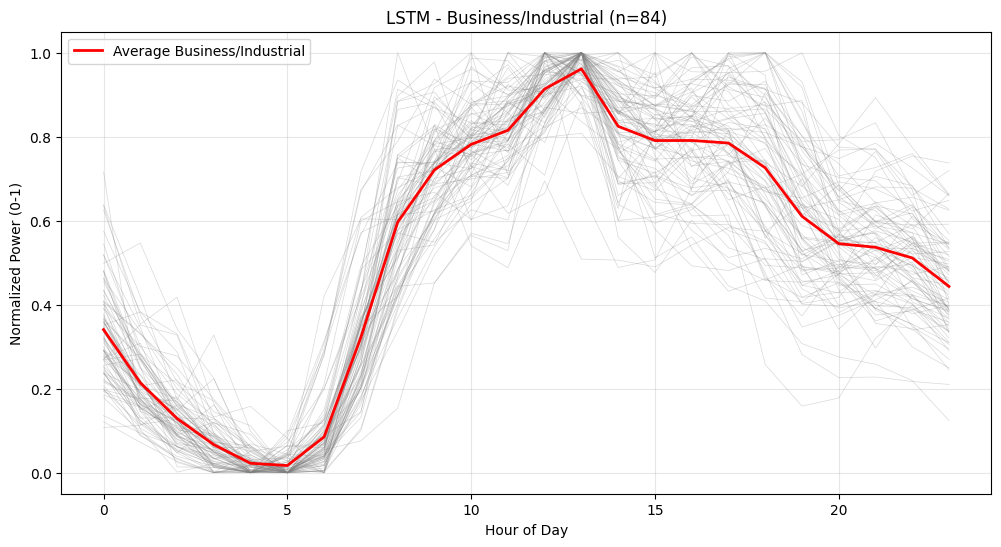

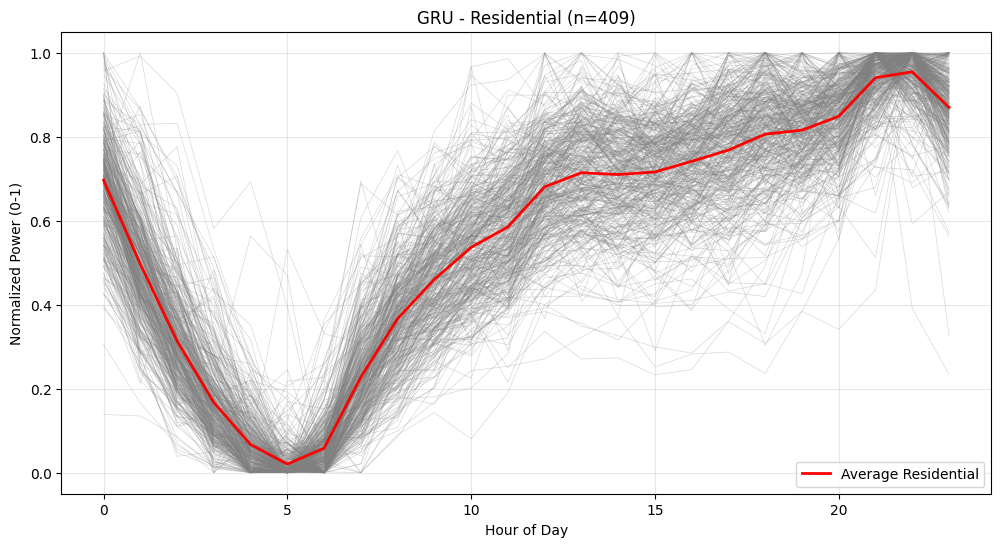

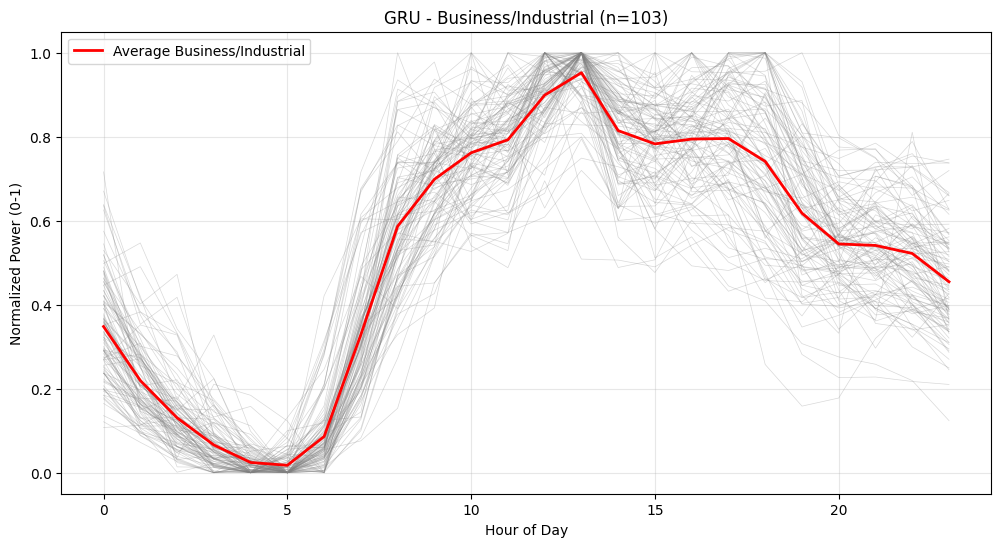

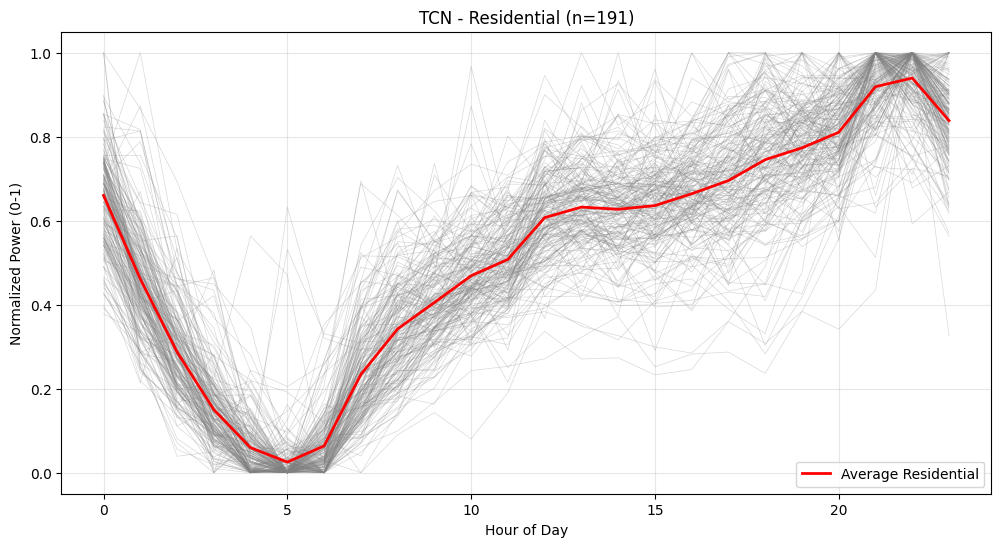

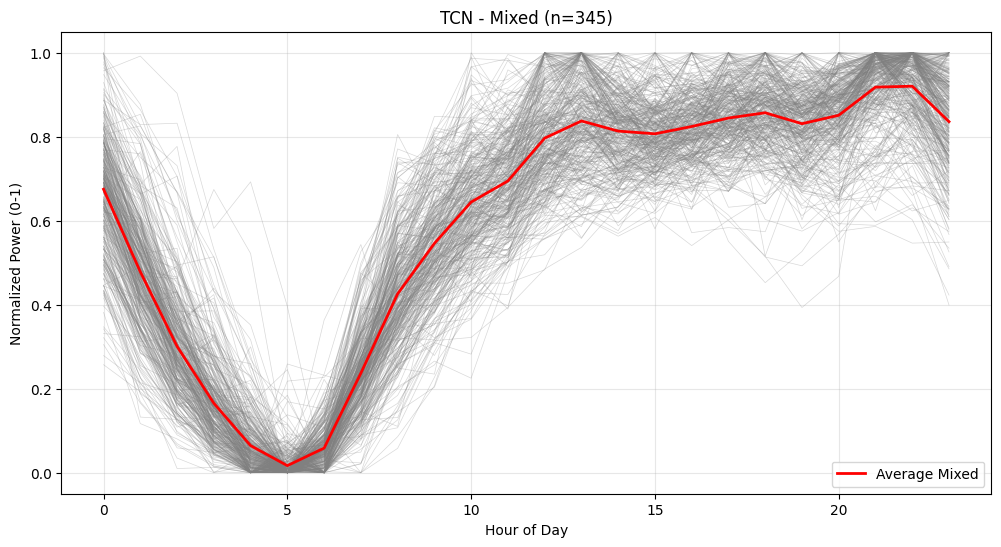

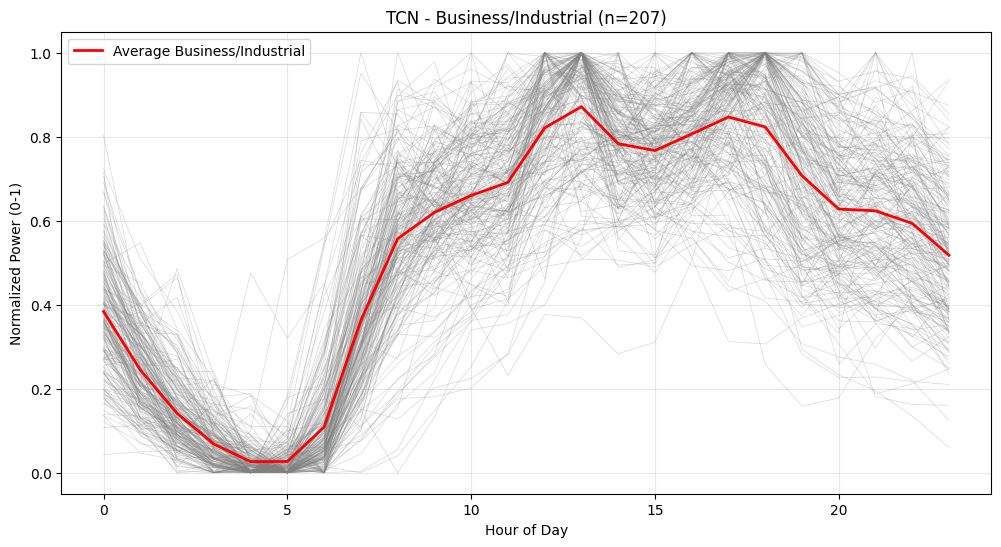

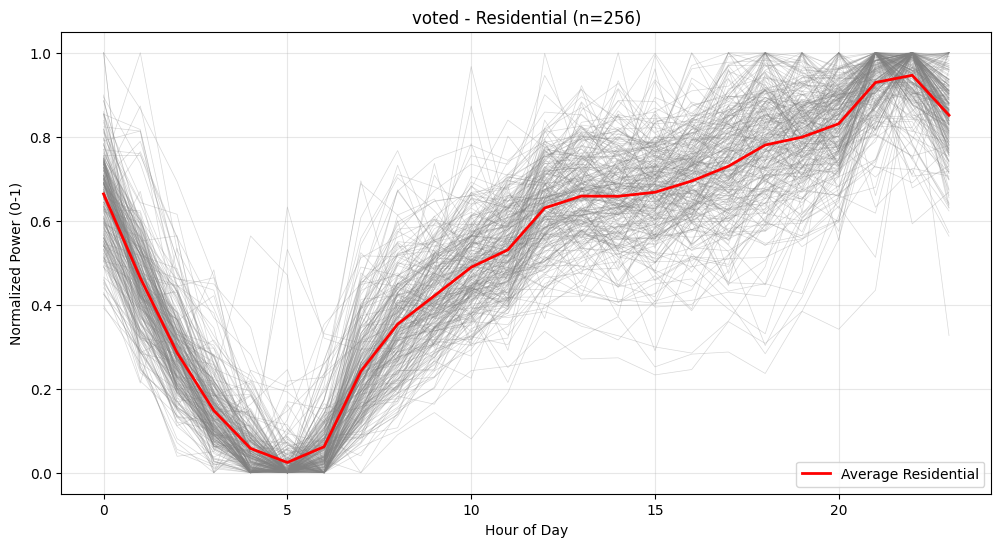

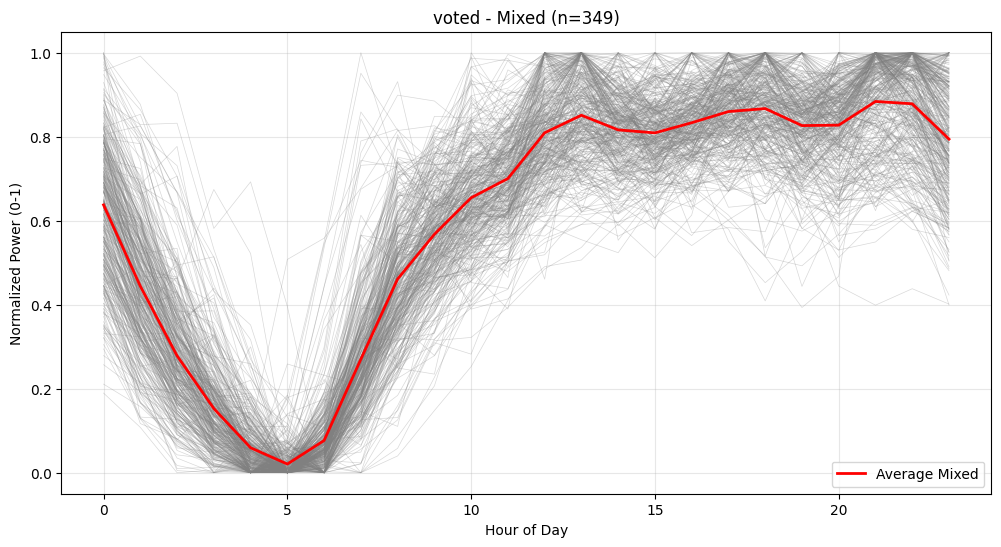

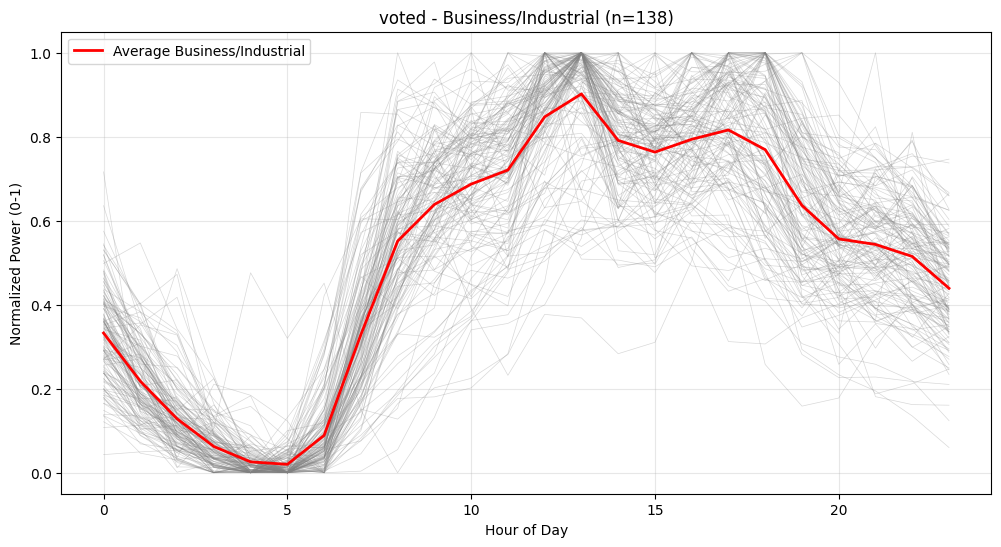

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['KMeans', 'LSTM', 'GRU', 'TCN', 'voted']
classes = ['Residential', 'Mixed', 'Business/Industrial']
hours = np.arange(24)

for model in models:
    for cls in classes:
        plt.figure(figsize=(12, 6))

        # Get BS Names classified as `cls` by the current model
        bs_list = clustered[clustered[model] == cls]['BS Name']

        # Extract and plot individual curves
        for bs in bs_list:
            bs_power = main_data_normalized[main_data_normalized['site'] == bs].iloc[:, 1:].values.flatten()
            plt.plot(hours, bs_power, color='gray', alpha=0.3, linewidth=0.5)

        # Calculate and plot the average curve
        class_power = main_data_normalized[main_data_normalized['site'].isin(bs_list)].iloc[:, 1:]
        avg_power = class_power.mean(axis=0)
        plt.plot(hours, avg_power, color='red', linewidth=2, label=f'Average {cls}')

        # Customize plot
        plt.title(f"{model} - {cls} (n={len(bs_list)})")
        plt.xlabel("Hour of Day")
        plt.ylabel("Normalized Power (0-1)")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

In [ ]:
import numpy as np

models = ['KMeans', 'LSTM', 'GRU', 'TCN', 'voted']
classes = ['Residential', 'Mixed', 'Business/Industrial']
metrics = {}

for model in models:
    metrics[model] = {}
    for cls in classes:
        # Get BS Names classified as `cls` by the current model
        bs_list = clustered[clustered[model] == cls]['BS Name']

        # Extract power data for these BSs
        class_power = main_data_normalized[main_data_normalized['site'].isin(bs_list)].iloc[:, 1:]
        avg_power = class_power.mean(axis=0)  # P_bar (average curve)

        # Calculate relative deviations: (P(n) - P_bar) / P_bar
        relative_deviations = (class_power - avg_power) / (avg_power + 1e-10)  # Avoid division by zero

        # Flatten to hourly deviations across all BSs
        deviations_flat = relative_deviations.values.flatten()
        deviations_flat = deviations_flat[~np.isnan(deviations_flat)]  # Remove NaNs

        # Compute metrics
        mrd = np.mean(np.abs(deviations_flat))  # Mean Relative Deviation
        rmsrd = np.sqrt(np.mean(deviations_flat**2))  # RMS Relative Deviation

        metrics[model][cls] = {
            'MRD': mrd,
            'RMSRD': rmsrd,
            'n_BS': len(bs_list)  # Number of BS in group
        }

In [ ]:
import pandas as pd

# Convert metrics dict to a readable DataFrame
metrics_df = pd.DataFrame.from_dict(
    {(model, cls): metrics[model][cls] for model in models for cls in classes},
    orient='index'
)
metrics_df.index.names = ['Model', 'Class']
metrics_df.reset_index(inplace=True)

print(metrics_df)

     Model                Class       MRD     RMSRD  n_BS
0   KMeans          Residential  0.267966  0.689596   398
1   KMeans                Mixed  0.286132  0.633245   225
2   KMeans  Business/Industrial  0.329363  0.703711   120
3     LSTM          Residential  0.274129  0.683868   286
4     LSTM                Mixed  0.307289  0.681761   373
5     LSTM  Business/Industrial  0.296858  0.541740    84
6      GRU          Residential  0.272151  0.659127   409
7      GRU                Mixed  0.296254  0.711497   231
8      GRU  Business/Industrial  0.301971  0.559309   103
9      TCN          Residential  0.280882  0.730130   191
10     TCN                Mixed  0.257187  0.622096   345
11     TCN  Business/Industrial  0.328070  0.660834   207
12   voted          Residential  0.275628  0.704092   256
13   voted                Mixed  0.274336  0.645150   349
14   voted  Business/Industrial  0.325069  0.665416   138


In [ ]:
from scipy.stats import spearmanr, pearsonr

models = ['KMeans', 'LSTM', 'GRU', 'TCN', 'voted']
classes = ['Residential', 'Mixed', 'Business/Industrial']
corr_methods = {'Pearson': pearsonr, 'Spearman': spearmanr}

# Dictionary to store all matrices
all_correlations = {model: {method: None for method in corr_methods}
                   for model in models}

for model in models:
    # Get average curves for each class
    avg_curves = []
    for cls in classes:
        bs_list = clustered[clustered[model] == cls]['BS Name']
        class_power = main_data_normalized[main_data_normalized['site'].isin(bs_list)].iloc[:,1:]
        avg_curves.append(class_power.mean(axis=0).values)

    # Calculate both correlation types
    for method_name, method_func in corr_methods.items():
        corr_matrix = np.zeros((3,3))
        for i in range(3):
            for j in range(3):
                corr, _ = method_func(avg_curves[i], avg_curves[j])
                corr_matrix[i,j] = corr
        all_correlations[model][method_name] = pd.DataFrame(
            corr_matrix,
            index=classes,
            columns=classes
        )

In [ ]:
def convert_to_probability(corr_matrix):
    """Apply softmax row-wise to convert correlations to probabilities"""
    prob_matrix = np.zeros_like(corr_matrix)
    for i in range(3):
        row = corr_matrix.iloc[i].values
        # Shift to positive values (softmax works better)
        row_shifted = row - np.min(row) + 0.01
        prob_row = np.exp(row_shifted) / np.sum(np.exp(row_shifted))
        prob_matrix[i] = prob_row
    return pd.DataFrame(prob_matrix,
                       index=corr_matrix.index,
                       columns=corr_matrix.columns)

# Store probabilistic matrices
all_probabilities = {model: {} for model in models}

for model in models:
    for method in ['Pearson', 'Spearman']:
        all_probabilities[model][method] = convert_to_probability(
            all_correlations[model][method]
        )

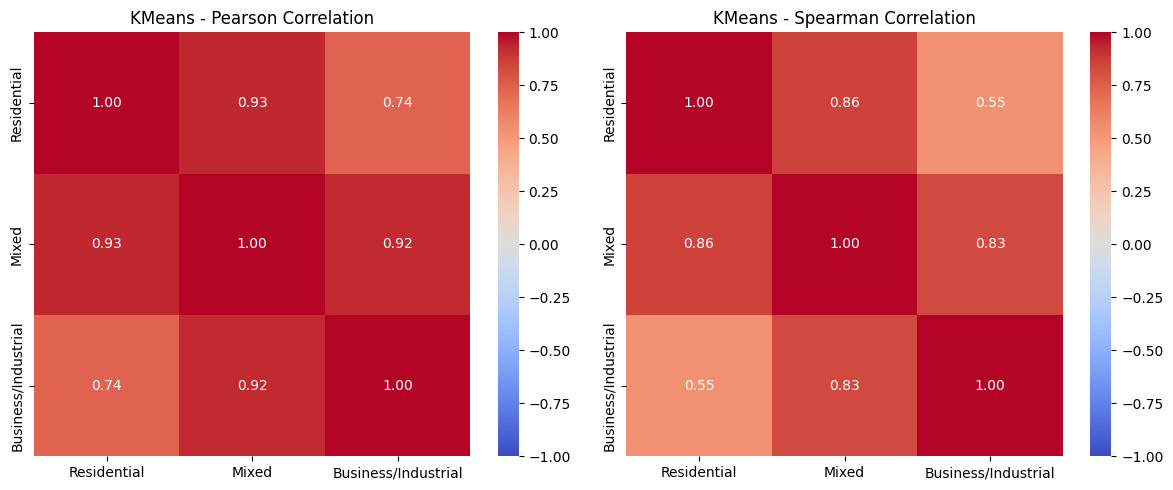

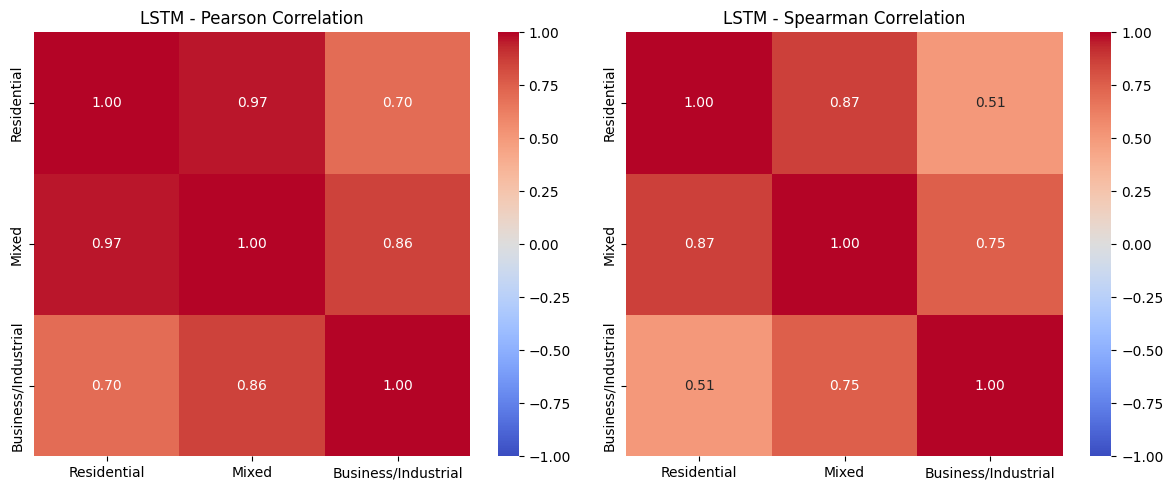

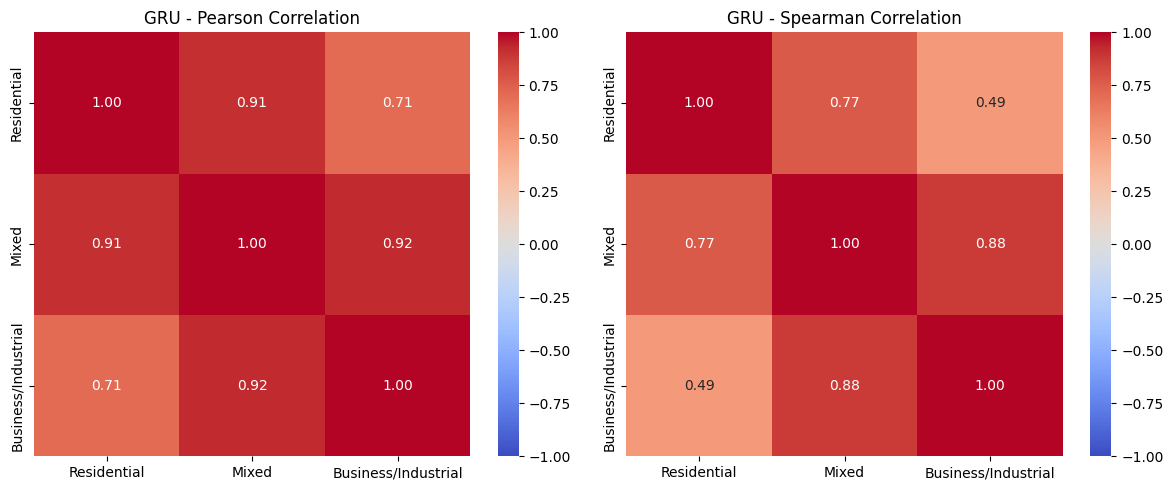

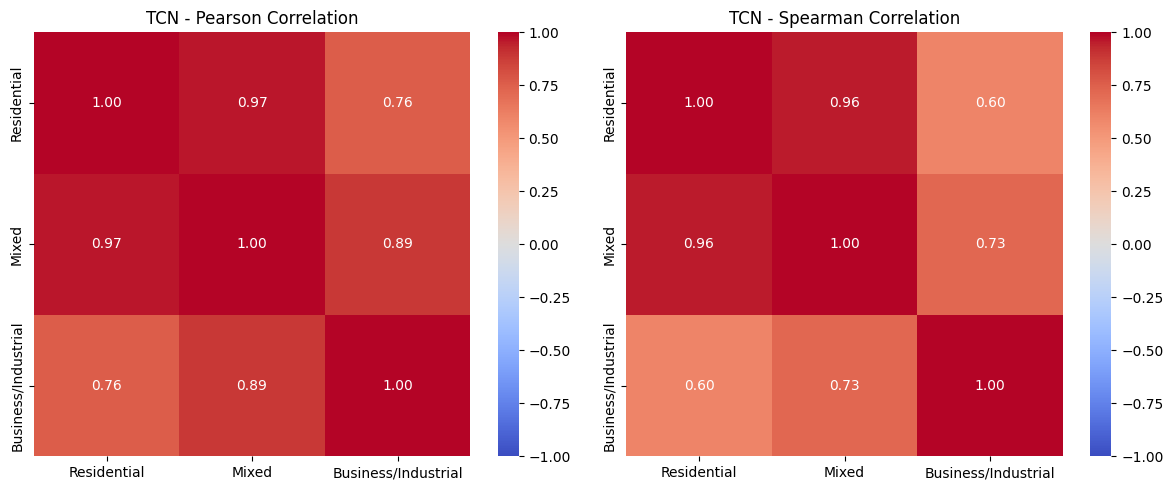

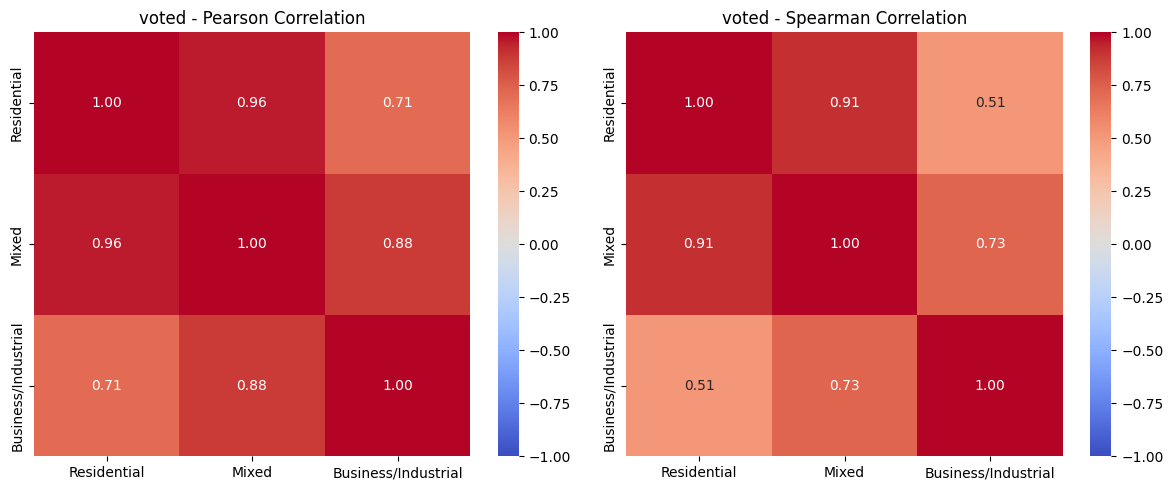

In [ ]:
for model in models:
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    for ax, (method, matrix) in zip(axes, all_correlations[model].items()):
        sns.heatmap(matrix, annot=True, fmt=".2f", cmap="coolwarm",
                   vmin=-1, vmax=1, ax=ax)
        ax.set_title(f"{model} - {method} Correlation")
    plt.tight_layout()
    plt.show()

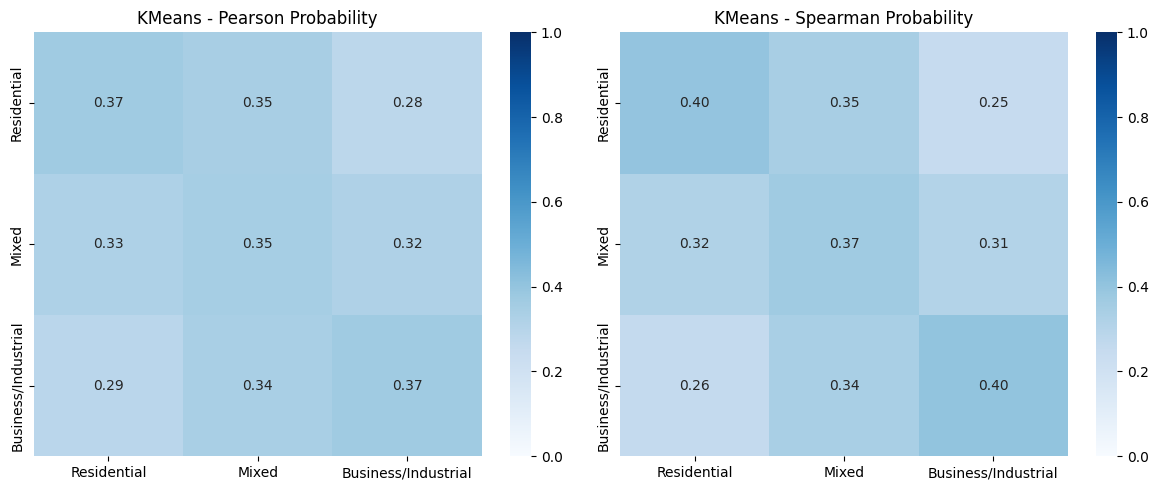

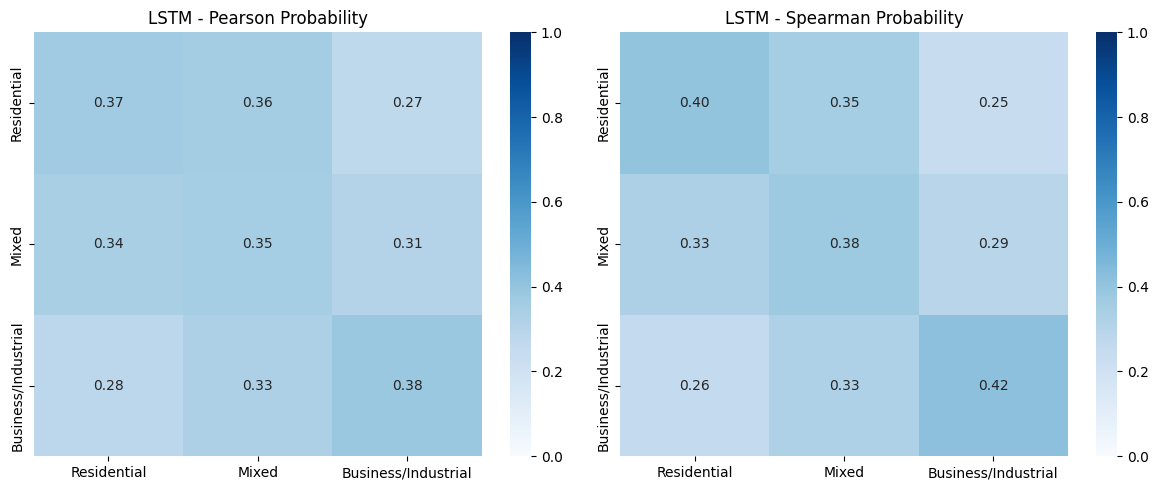

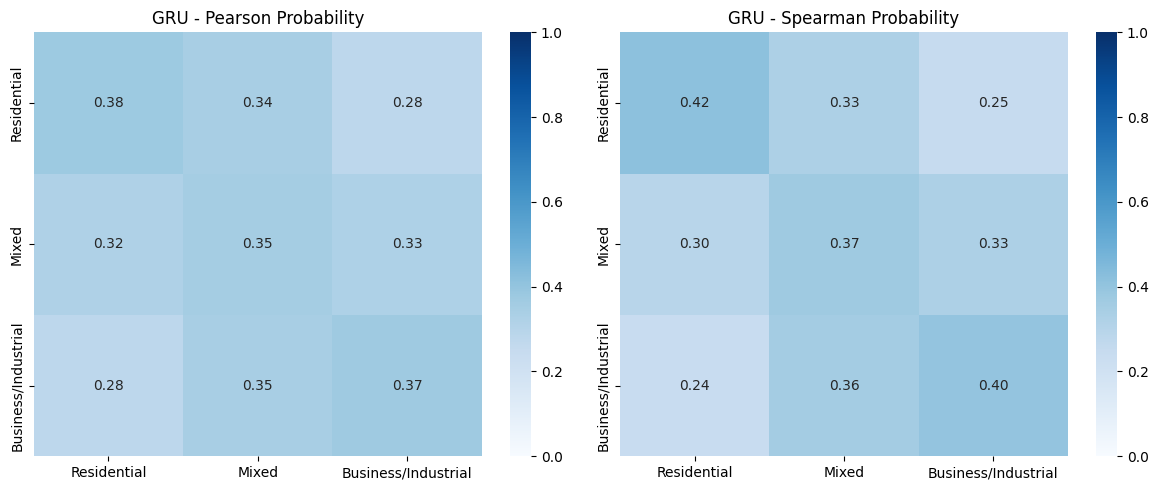

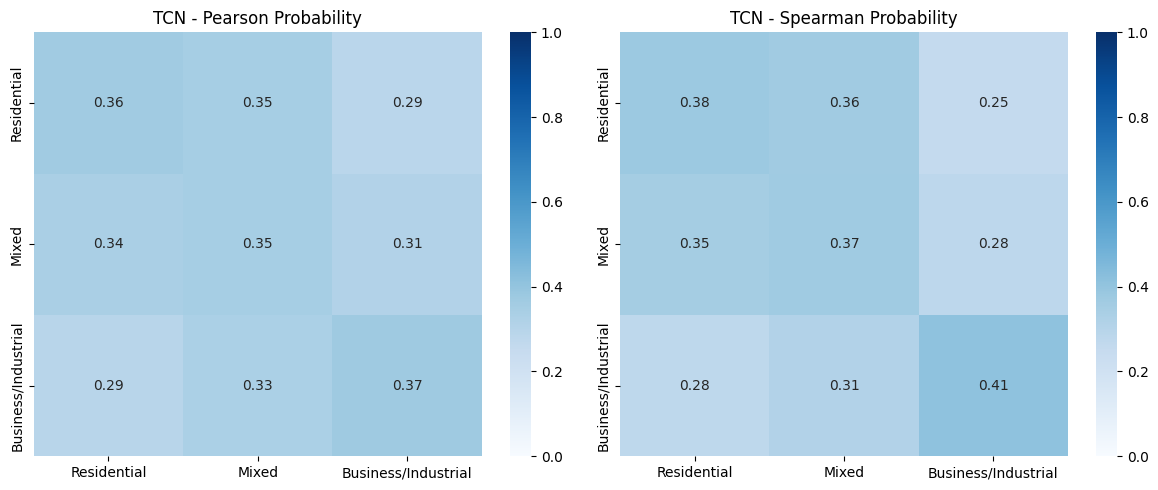

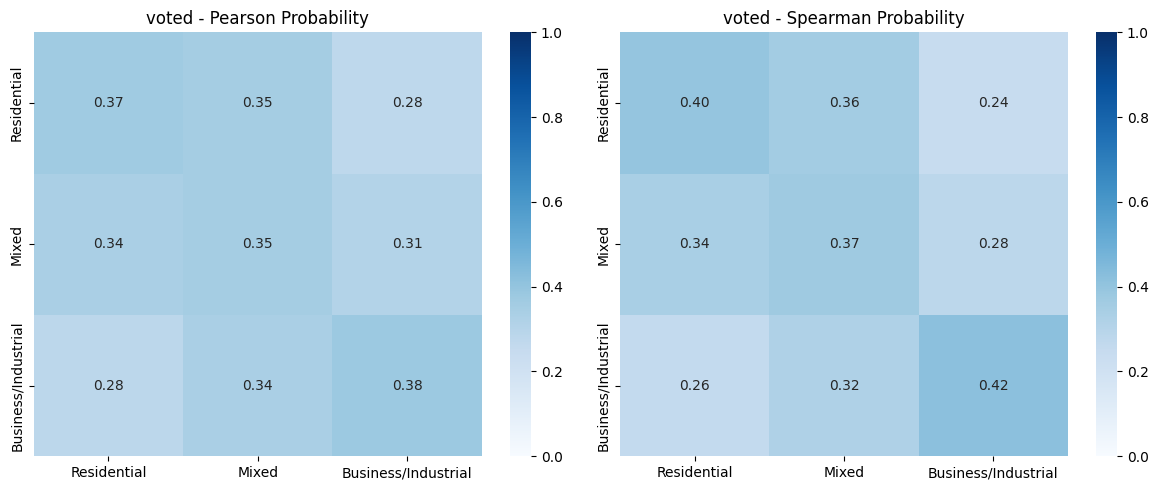

In [ ]:
for model in models:
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    for ax, (method, matrix) in zip(axes, all_probabilities[model].items()):
        sns.heatmap(matrix, annot=True, fmt=".2f", cmap="Blues",
                   vmin=0, vmax=1, ax=ax)
        ax.set_title(f"{model} - {method} Probability")
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Feature matrix (n_samples × n_hours)
X = main_data_normalized.iloc[:, 1:].values

# Standardize features
X_scaled = StandardScaler().fit_transform(X)
# Use MinMaxScaler instead of StandardScaler for cosine similarity
from sklearn.preprocessing import MinMaxScaler
X_mmscaled = MinMaxScaler().fit_transform(X)  # Power curves scaled to [0,1]


In [ ]:
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    pairwise_distances  # For cosine distance
)
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Initialize metrics storage
metrics = {
    'Model': [],
    'Silhouette': [],
    'Davies-Bouldin': [],
    'Calinski-Harabasz': [],
    'Cosine_Similarity_Avg': []  # Average pairwise cosine similarity between clusters
}

for model in ['KMeans', 'LSTM', 'GRU', 'TCN', 'voted']:
    # Convert class labels to numeric
    labels = clustered[model].map({
        'Residential': 0,
        'Mixed': 1,
        'Business/Industrial': 2
    })

    # Get power curve features and standardize
    X = main_data_normalized.iloc[:, 1:].values
    X_scaled = StandardScaler().fit_transform(X)

    # Calculate cluster centroids
    centroids = np.array([X_mmscaled[labels == i].mean(axis=0) for i in range(3)])

    # Compute pairwise cosine distances (0=identical, 1=orthogonal)
    cosine_dist = pairwise_distances(centroids, metric='cosine')

    # Store metrics
    metrics['Model'].append(model)
    metrics['Silhouette'].append(silhouette_score(X_scaled, labels))
    metrics['Davies-Bouldin'].append(davies_bouldin_score(X_scaled, labels))
    metrics['Calinski-Harabasz'].append(calinski_harabasz_score(X_scaled, labels))

    # Average cosine similarity between different clusters (ignore diagonal)
    np.fill_diagonal(cosine_dist, np.nan)
    metrics['Cosine_Similarity_Avg'].append(np.nanmean(cosine_dist))

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics)
print(metrics_df.sort_values('Silhouette', ascending=False))

    Model  Silhouette  Davies-Bouldin  Calinski-Harabasz  \
2     GRU    0.153851        2.089225         137.855102   
3     TCN    0.140546        1.801761         152.942436   
4   voted    0.134919        1.930895         147.947023   
0  KMeans    0.120057        2.286187         124.763354   
1    LSTM    0.084715        2.498867          93.886087   

   Cosine_Similarity_Avg  
2               0.053424  
3               0.045044  
4               0.055107  
0               0.046612  
1               0.058387  


In [ ]:
import seaborn as sns

for model in ['LSTM', 'TCN']:  # Compare two models
    labels = clustered[model].map({'Residential':0, 'Mixed':1, 'Business/Industrial':2})
    centroids = np.array([X_mmscaled[labels==i].mean(axis=0) for i in range(3)])
    cosine_dist = pairwise_distances(centroids, metric='cosine')

    plt.figure()
    sns.heatmap(cosine_dist, annot=True, xticklabels=classes, yticklabels=classes)
    plt.title(f"{model} - Cosine Distance Between Clusters")